In [1]:
# In this notebook we will use transfer learning by fine-tuning approach.
# We will try two ways to customize our pretrained model DenseNet:
# 1. Feature Extraction: We use the representations learned by a pretrained network to extract meaningful
# features from new samples. We simply add a new classifier which will be trained from scratch, on top of 
# pretrained model so that you can repurpose the feature maps learned previously for the dataset.
# In this approach, we do not need to re-train the entire model. The base CNN(pretrained) already contains
# features that are generically useful for classifying pictures. But, the final,classification part of the
# pretrained model is specific to the original classification task, and subsequently specific to the set of
# classes on which the model was trained.

# 2. Fine-Tuning: Unfreeze a few of the top layers of a frozen model baseand jointly train noth the newly-added
# classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-orde feature
# representations in the base mdoel in order to make them more relevant for the specific task.

# We will follow the workflow of,
# 1. Examine and udnerstand the data
# 2. Build an input pipeline, in this case using Keras ImageDataGenerator
# 3. Compose the model
#    3.1. Load in the pretrained base model (and pretrained weights)
#    3.2. Stack the classification layers on top
#4. Train the mdoel
#5. Evaluate the model

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
# DATA PREPROCESSING
# Load the dataset

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

dir = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset'

dataset = tf.keras.utils.image_dataset_from_directory(      dir,
                                                            shuffle=True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size= IMG_SIZE    )

Found 4575 files belonging to 3 classes.


In [5]:
class_names= dataset.class_names
class_names

['covid', 'normal', 'pneumonia']

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        dir,
        target_size=(160, 160),
        batch_size=32,
        shuffle=True,
       
       class_mode="categorical")

class_indices = train_generator.class_indices

Found 4575 images belonging to 3 classes.


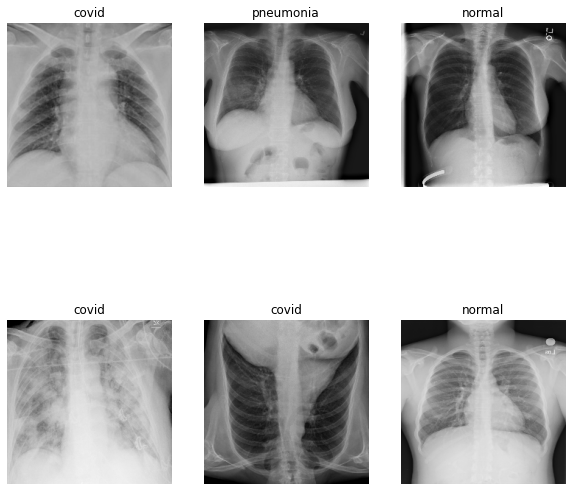

In [7]:
# Observing some samples from the dataset

class_names = dataset.class_names


plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Defining a function for the train, validation, and test split.

def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    

    return train_ds, val_ds, test_ds

In [9]:
# Split the dataset into train, validation and test sets.
# Call the function get_dataset_partitions_pd

train_dataset, validation_dataset, test_dataset = get_dataset_partitions_tf( dataset, ds_size=len(dataset))

In [10]:
# Use buffered prefetching by tensorflow data library to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [11]:
# Dataset Augmentation

# When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity 
# by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. 
# This helps expose the model to different aspects of the training data and reduce overfitting.


data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

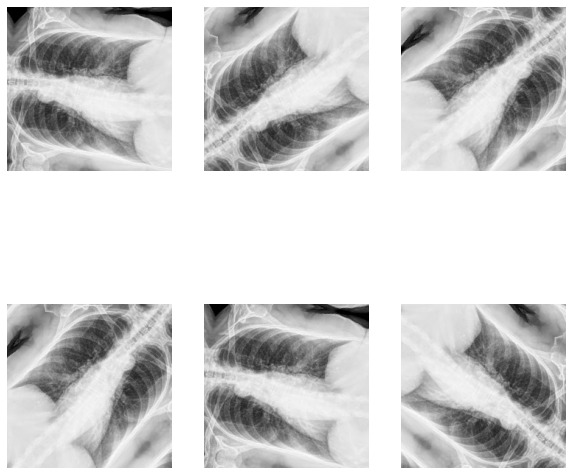

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
# Rescale pixel values and downloading our base model densenet
# For the Densenet pretrained models, the input pixels values are scaled between 0 and 1; [0,1] and each channel is normalized 
# with respect to the ImageNet dataset.
# Reference 1, https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/preprocess_input
# Reference 2, https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling

# To rescale an input in the [0, 255] range to be in the [0, 1] range, you would pass scale=1./255.

rescale = tf.keras.layers.Rescaling(1./255, offset=0.0)

# Download the densenet preprocessing tool

preprocess_input = tf.keras.applications.densenet.preprocess_input


In [14]:
# CREATE THE BASE MODEL FROM PRETRAINED NETWORKS
# We use the densely connected neural networks of type Densenet121, 
# Reference, https://arxiv.org/abs/1608.06993

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Then we'll pick which layer of Densenet will be used for feature extraction. 
# The very last classification layer is not very useful, because on "top", 
# as most diagrams of machine learning models go from bottom to top.

# Instead, you will follow the common practice to depend on the very last layer before the flatten operation. 
# This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared 
# to the final/top layer.

# First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument,
# you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

29097984/29084464 [==============================] - 0s 0us/step


In [15]:
# This feature extractor converts each 224x224x3 image into a 7x7x1024 block of features. 
# We can see what it does to an example batch of images as follows,

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [16]:
# Feature Extraction Approach

# Now we will freeze the convolutional base created from the previous step
# and use as a feature extractor. Additionally, we will add a classifier on top
# of it and train the top-level classifier.

# Freezing the convolutional base

# Now we will freeze the convolutional base before we compile and train the model.
# Freezing prevents the weights in a given layer from being updated during training.
# Setting the entire model's trainable flag to False will freeze all of them.

base_model.trainable = False


In [17]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [18]:
# Add a classification head

# In order to generate predictions from the block of features, average over the
# spatial 5 x 5 spatial locations, using tf.keras.layers.GlobalAveragePooling2D
# layer to convert the features to a single vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [19]:
# Now we'll convert these features into a single prediction per image.
# We don't need an activation function here because this prediction 
# will be treated as a logit, or a raw prediction value.

prediction_layer = tf.keras.layers.Dense(3,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [20]:
#Build a model by chaining together the data augmentation, rescaling, base_model and 
#feature extractor layers using the Keras Functional API. As previously mentioned, 
#use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
#COMPILE THE MODEL

#Compile the model before training it, since there are three classes we'll use SparseCategoricalCrossEntropy. 
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        703750

In [23]:
#These are the weight and bias

len(model.trainable_variables)

2

In [24]:
# TRAIN THE MODEL

initial_epochs = 4

loss0, accuracy0 = model.evaluate(validation_dataset)

14/14 [==============================] - 105s 4s/step - loss: 1.4159 - accuracy: 0.4174


In [25]:
print("initial loss:", loss0)
print("initial accuracy:",accuracy0)

initial loss: 1.415905237197876
initial accuracy: 0.4174107015132904


In [26]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('covid_19')

checkpoint = ModelCheckpoint(weight_path,
                             save_best_only=True, save_weights_only = True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5) 

callbacks_list = [checkpoint, early]

history = model.fit(train_dataset,epochs=initial_epochs,validation_data=validation_dataset, callbacks = callbacks_list)

Epoch 1/4
114/114 [==============================] - 622s 5s/step - loss: 1.1481 - accuracy: 0.4382 - val_loss: 0.9450 - val_accuracy: 0.5469
Epoch 2/4
114/114 [==============================] - 619s 5s/step - loss: 0.8663 - accuracy: 0.6123 - val_loss: 0.7463 - val_accuracy: 0.7344
Epoch 3/4
114/114 [==============================] - 980s 8s/step - loss: 0.7187 - accuracy: 0.7022 - val_loss: 0.6735 - val_accuracy: 0.7366
Epoch 4/4
114/114 [==============================] - 633s 5s/step - loss: 0.6403 - accuracy: 0.7508 - val_loss: 0.6246 - val_accuracy: 0.7723


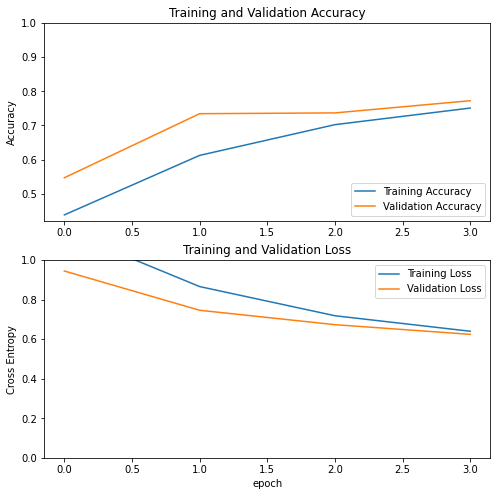

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [28]:
# Fine Tuning Approach
# In the feature extraction experiment, you were only training a few layers on top of an 
# MobileNetV2 base model. The weights of the pre-trained network were not updated during training.


# One way to increase performance even further is to train (or "fine-tune") the weights of the
# top layers of the pre-trained model alongside the training of the classifier you added. 
# The training process will force the weights to be tuned from generic feature maps to 
# features associated specifically with the dataset.

# Unfreeze the top layers of the model

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  427


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        703750

In [31]:
len(model.trainable_variables)

281

In [32]:
#Continue training the model

fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 4/8
114/114 [==============================] - 1357s 11s/step - loss: 0.4026 - accuracy: 0.8659 - val_loss: 0.2674 - val_accuracy: 0.9286
Epoch 5/8
114/114 [==============================] - 1298s 11s/step - loss: 0.2863 - accuracy: 0.9114 - val_loss: 0.2273 - val_accuracy: 0.9241
Epoch 6/8
114/114 [==============================] - 1290s 11s/step - loss: 0.2536 - accuracy: 0.9145 - val_loss: 0.2697 - val_accuracy: 0.9085
Epoch 7/8
114/114 [==============================] - 1306s 11s/step - loss: 0.2219 - accuracy: 0.9287 - val_loss: 0.1581 - val_accuracy: 0.9487
Epoch 8/8
114/114 [==============================] - 1291s 11s/step - loss: 0.2147 - accuracy: 0.9315 - val_loss: 0.1887 - val_accuracy: 0.9442


In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

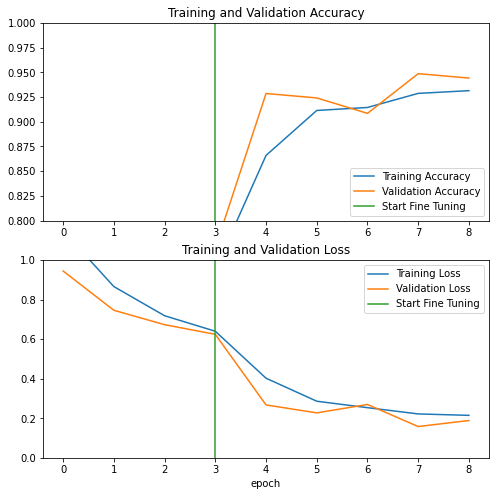

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
# Evaluation and Prediction

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

15/15 [==============================] - 107s 4s/step - loss: 0.1779 - accuracy: 0.9458
Test accuracy : 0.9458333253860474


Predictions:
 [0 1 2 1 1 1 0 0 2 2 0 1 2 1 0 1 2 0 2 0 0 0 0 0 0 0 0 2 0 0 2 2]
Labels:
 [1 0 2 1 1 1 0 0 2 2 1 1 2 1 0 1 2 0 2 1 0 0 0 0 0 0 0 2 0 0 2 2]


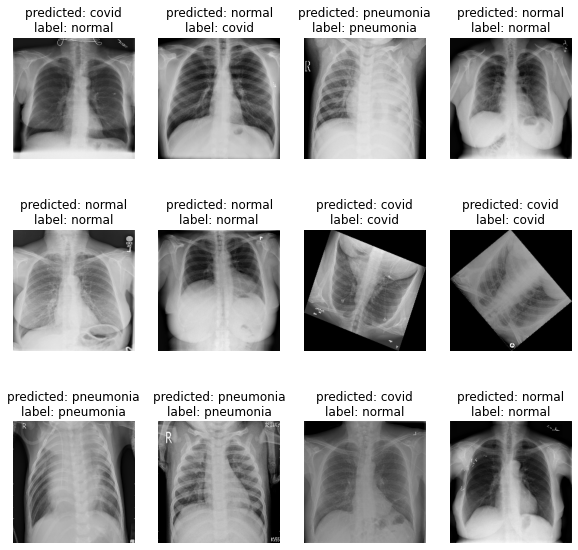

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
y_true=label_batch
# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
y_pred_proba=np.amax(predictions,1)
predictions = np.argmax(predictions, 1)
y_pred=predictions
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(12):
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('predicted: ' + class_names[predictions[i]]+'\n'+ 'label: ' +class_names[label_batch[i]])
  plt.axis("off")

In [37]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('int') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return 

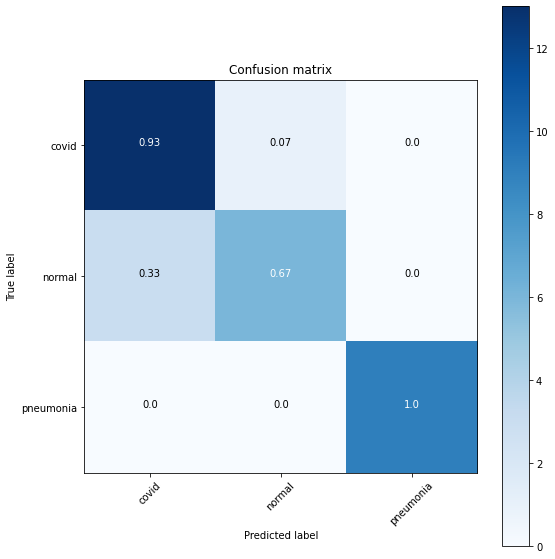

In [38]:
#Plotting the confusion matrix

import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

confusion_matrix

plot_confusion_matrix(confusion_matrix, class_names)

In [39]:
from sklearn.metrics import precision_score , recall_score
import sklearn.metrics as metrics
from sklearn.metrics import classification_report


def calculate_metrics1(y_true,y_pred):
    print(classification_report(y_true, y_pred))

calculate_metrics1(y_true,y_pred)

              precision    recall  f1-score   support

           0       0.81      0.93      0.87        14
           1       0.86      0.67      0.75         9
           2       1.00      1.00      1.00         9

    accuracy                           0.88        32
   macro avg       0.89      0.87      0.87        32
weighted avg       0.88      0.88      0.87        32



In [40]:
from keras.preprocessing import image

def single_image_test(path):
    test_image = image.load_img(path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)

    predictions_x = tf.nn.softmax(result)
    predictions = np.argmax(predictions_x, 1)
    predictions_percent=np.array(predictions_x)*100
  
    print('Predicted Diagnosis is: ',class_names[predictions[0]])

    return class_names[predictions[0]],predictions_percent #[0,predictions[0]]

In [41]:
def get_probs(class_names,predictions_percent):
    for i in range(3):
        print(class_names[i].ljust(50,'_'),'%', predictions_percent[0][i])

In [42]:
def display_image(path):
    test_image = image.load_img(path, target_size = (224, 224))
    test_image = image.img_to_array(test_image)
    
    plt.imshow(test_image/255)

In [43]:
def single_super_test(path):
    predictions,predictions_percent=single_image_test(path)
    display_image(path)
    get_probs(class_names,predictions_percent)

In [44]:
path_to_covid = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/COVID19(572).jpg'
path_to_covid2 = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/COVID19(555).jpg'
path_to_covid3 = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/covid/COVID19(532).jpg'

path_to_pneumonia = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person1599_bacteria_4201.jpeg'
path_to_pneumonia2 = '/content/drive/My Drive/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/pneumonia/person1591_virus_2765.jpeg' 


Predicted Diagnosis is:  covid
covid_____________________________________________ % 57.387733
normal____________________________________________ % 21.27971
pneumonia_________________________________________ % 21.332558


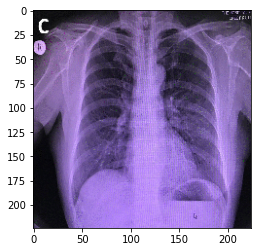

In [45]:
single_super_test(path_to_covid )

Predicted Diagnosis is:  covid
covid_____________________________________________ % 57.537056
normal____________________________________________ % 21.216202
pneumonia_________________________________________ % 21.246738


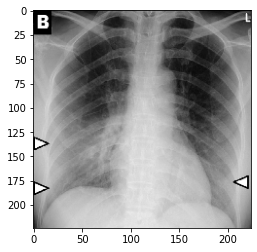

In [46]:
single_super_test(path_to_covid2 )

Predicted Diagnosis is:  covid
covid_____________________________________________ % 54.676456
normal____________________________________________ % 23.009481
pneumonia_________________________________________ % 22.314072


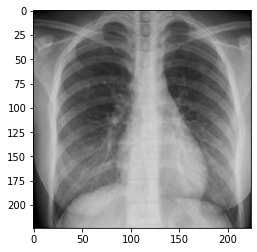

In [47]:
single_super_test(path_to_covid3 )

Predicted Diagnosis is:  pneumonia
covid_____________________________________________ % 24.623186
normal____________________________________________ % 21.997896
pneumonia_________________________________________ % 53.378914


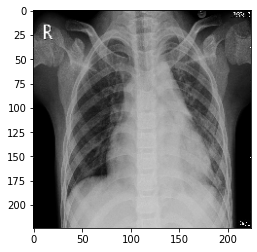

In [48]:
single_super_test(path_to_pneumonia2 )

Predicted Diagnosis is:  pneumonia
covid_____________________________________________ % 28.072374
normal____________________________________________ % 22.64201
pneumonia_________________________________________ % 49.285618


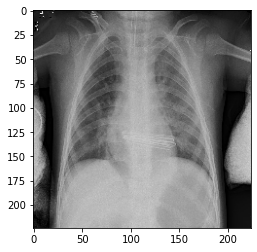

In [49]:
single_super_test(path_to_pneumonia )

In [50]:
label_batch

array([1, 0, 2, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 2, 2], dtype=int32)

In [51]:
for idx in range(len(base_model.layers)):
    print(base_model.get_layer(index = idx).name)

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [52]:
for layer in model.layers:
    print(layer.name)

input_2
sequential
tf.math.truediv
tf.nn.bias_add
tf.math.truediv_1
densenet121
global_average_pooling2d
dropout
dense


In [53]:
# Now we will produce the GradCam Heatmap on the images
# Producing the heatmap

from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import tensorflow.keras.backend as K
import cv2

In [63]:
#Let's save the weights :)

model.save_weights('/content/drive/My Drive/covid_checkpoint_2/')

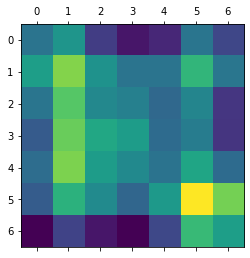

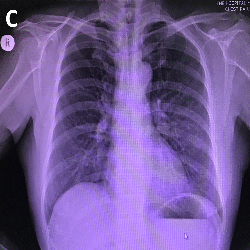

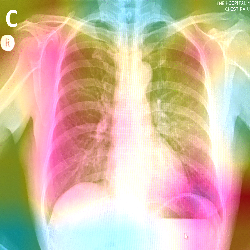

In [55]:
from google.colab.patches import cv2_imshow

def produce_heatmap(path):
 
        image_f = image.load_img(path, target_size = (224, 224))
        x = image.img_to_array(image_f)
        x = np.expand_dims(x, axis = 0)
        x = tf.keras.applications.densenet.preprocess_input(x)

        preds = model.predict(x)
        preds = tf.nn.softmax(preds)
        preds = np.argmax(preds, 1)

        with tf.GradientTape() as tape:
              last_conv_layer = model.get_layer('densenet121').get_layer('conv5_block16_concat')
              iterate = tf.keras.models.Model([model.get_layer('densenet121').inputs], [model.get_layer('densenet121').output, last_conv_layer.output])
              model_out, last_conv_layer = iterate(x)
              class_out = model_out[:,:,:,:np.argmax(model_out[0])]
              grads = tape.gradient(class_out, last_conv_layer)
              pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        heatmap = heatmap.reshape((7, 7))
        plt.matshow(heatmap)
        plt.show()

        img=cv2.imread(path)

        INTENSITY = 0.5

        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

        img = heatmap * INTENSITY + img

        imS = cv2.resize(cv2.imread(path), (250, 250))  
        imS2 = cv2.resize(img, (250, 250))

        cv2_imshow(imS)
        cv2_imshow(imS2)

        
        
        #plt.imshow(cv2.imread(path).astype('uint8'))
        #plt.imshow(img.astype('uint8'))
        #plt.show()

produce_heatmap(path_to_covid)

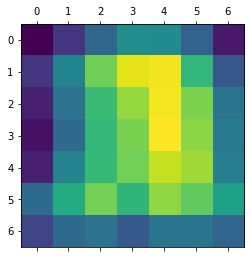

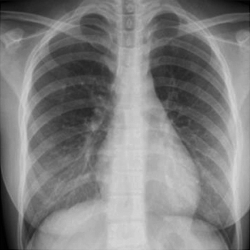

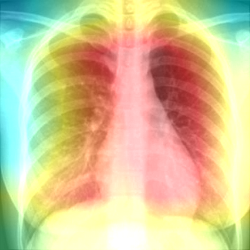

In [56]:
produce_heatmap(path_to_covid3)

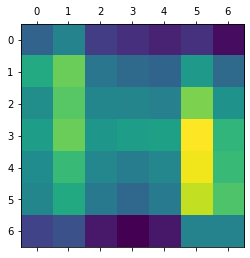

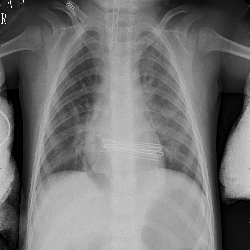

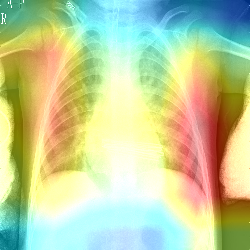

In [57]:
produce_heatmap(path_to_pneumonia)

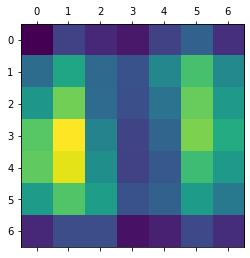

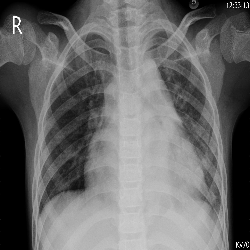

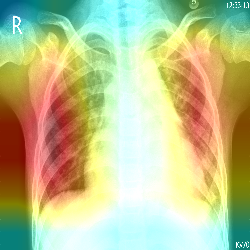

In [58]:
produce_heatmap(path_to_pneumonia2)

In [59]:
!pip install graphviz

In [60]:
!pip install pydotplus

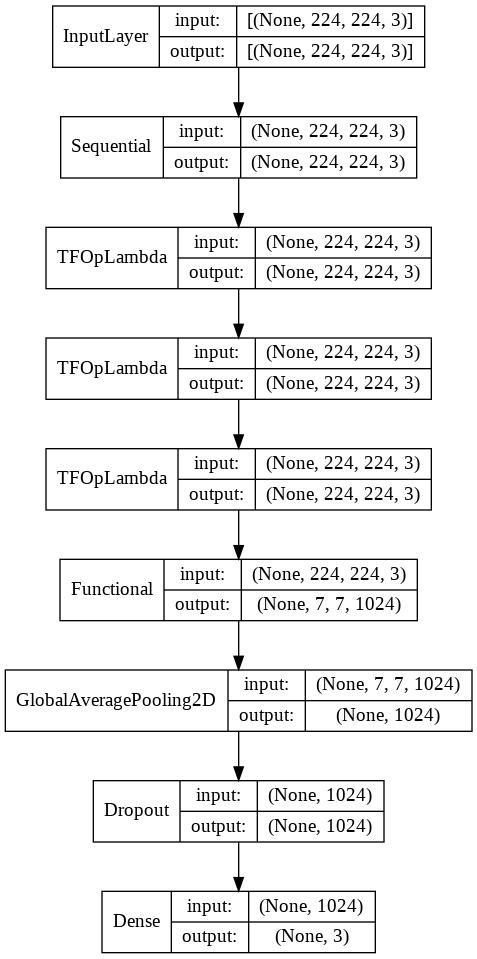

In [61]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes = True, show_layer_names = False)

In [67]:
model.save('/content/drive/My Drive/model.h5')